In [854]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import SVC, LinearSVC

plt.rcParams['figure.figsize'] = (25,5)

# Assignment 2 - Regression
### Predict the TOTAL COMPENSATION for this year. 

The data file provided is a salary survey for tech workers in Europe. We want to predict the total amount of compensation they bring in each year, based off of the details of their work. 

Some notes that will be important:
<ul>
    <li>The total compensation will need to be constructed, there is a column for salary, "Yearly brutto salary (without bonus and stocks) in EUR", as well as a column for bonus compensation, "Yearly bonus + stocks in EUR". 
    <li>Some categorical variables will need some work, and there isn't generally an exact answer. The main concern is things with categories that have a bunch of values with a very small count. For example, if there is only 1 person in City X, then that value likely needs to be addressed. We don't want it encoded into a new column of one 1 and thousands of 0s. 
    <li>There is an article exploring some of the data here: https://www.asdcode.de/2021/01/it-salary-survey-december-2020.html
    <li>Imputation and a bit of data manipulation will be required. 
    <li>Use any regression method you'd like. Some ones are closely related to what we've done, you may want to look at them, e.g. ExtraTreesRegressor. 
    <li>Initial accurracy, and potentially final accuracy, may not be great. When I made a plain model will little optimization the errors were large and the R2 was low. There is lots of room for optimization. 
    <li>Research challenge - try some work on the target, look into TransformedTargetRegressor and see if that helps. Recall in stats when we had skewed distributions... Maybe it helps, maybe it doesn't. 
    <li>EDA and data prep are up to you - you'll probably need to do a little exploring to figure out what cleanup is needed. When I did it, I did things kind of iteratively when I did it. For example, look at the value counts, figure out how to treat the different categories, clean something up, look at the results, potentially repeat if needed. After you figure out what needs to be done, you may be able to take some of those steps and incorporate them into a pipeline to be cleaner....
    <li><b>CRITICAL - Please make sure your code runs with RUN ALL. It should load the data that you're given, do all the processing, and spit out results. Comment out or remove anything that you've cleaned up and don't need - e.g. if you scaled a value manually, then moved that into a pipeline, don't leave the original scaling code active when the file is run.</b>
</ul>

### Details and Deliverables

You'll need to build code to produce the predictions. In particular, there's a few things that'll be marked:
<ul>
    <li>Please add a markdown cell at the bottom, and put in a few notes addressing the following:
    <ul>
        <li> Accuracy of your models with/without feature selection. Include both train/test for each. Please use R2 and RMSE. 
        <li> Feature Selection - Please identify what you did for feature selection. No need for a long explaination, something along the lines of "I did X, and the result was that 4 features were removed". Try at least 2 things. 
        <li> Hyperparameter Changes / Grid Search Improvements. What did you try, and why. Similar explaination to above, short. 
        <li> Overall this section should be roughly as long as this intro block - just outline what the results were, what you did to improve, and the results after. 
        <li> If you could use titles/bullet points I'd really appreciate it. 
    </ul>
    <li>Grade Breakdown:
    <ul>
        <li> Code is readable, there are comments: 20%
        <li> Explaination as defined above: 60% (20% each point)
        <li> Accuracy: 20% As compared to everyone else. This will be generously graded, I won't be surprised if overall accuracy is low for most people. 
    </ul>
</ul>

In [855]:
#Load Data
df = pd.read_csv("data/Euro_Salary.csv")
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Timestamp,1253,1248,24/11/2020 13:55:19,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,1226.0,NaN,NaN,NaN,32.509788,5.663804,20.0,29.0,32.0,35.0,69.0
Gender,1243,3,Male,1049,NaN,NaN,NaN,NaN,NaN,NaN,NaN
City,1253,119,Berlin,681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Position,1247,148,Software Engineer,387,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Total years of experience,1237,48,10,138,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Years of experience in Germany,1221,53,2,195,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Seniority level,1241,24,Senior,565,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Your main technology / programming language,1126,256,Java,184,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Other technologies/programming languages you use often,1096,562,Javascript / Typescript,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [856]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1253 entries, 0 to 1252
Data columns (total 18 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Timestamp                                               1253 non-null   object 
 1   Age                                                     1226 non-null   float64
 2   Gender                                                  1243 non-null   object 
 3   City                                                    1253 non-null   object 
 4   Position                                                1247 non-null   object 
 5   Total years of experience                               1237 non-null   object 
 6   Years of experience in Germany                          1221 non-null   object 
 7   Seniority level                                         1241 non-null   object 
 8   Your main technology / programming lan

In [857]:
df.sample(10)

,Timestamp,Age,Gender,City,Position,Total years of experience,Years of experience in Germany,Seniority level,Your main technology / programming language,Other technologies/programming languages you use often,Yearly brutto salary (without bonus and stocks) in EUR,Yearly bonus + stocks in EUR,Number of vacation days,Employment status,Сontract duration,Main language at work,Company size,Company type
372,24/11/2020 18:40:13,32.0,Male,Berlin,Software Engineer,12,1,Senior,Java,"Python, SQL, AWS, Kubernetes, Docker",83000.0,500,27,Full-time employee,Unlimited contract,English,1000+,Product
673,25/11/2020 18:56:02,51.0,Male,Berlin,Software Engineer,30,30,Senior,"VB, RPA, Python","Python, PHP, Javascript / Typescript, .NET, SQ...",60000.0,5000,30,Full-time employee,Unlimited contract,German,1000+,Consulting / Agency
573,25/11/2020 13:12:26,33.0,Male,Berlin,Backend Developer,11,4,Senior,Scala,"Java / Scala, AWS, Kubernetes, Docker",154000.0,NaN,22,Self-employed (freelancer),Temporary contract,German,11-50,Startup
809,26/11/2020 23:40:18,37.0,Male,Berlin,Software Engineer,11,5,Senior,Python,"C/C++, SQL, Docker",73000.0,30000,28,Full-time employee,Unlimited contract,English,101-1000,Product
813,27/11/2020 00:33:53,42.0,Male,Friedrichshafen,Software Engineer,20,1,Senior,C++,"Python, C/C++, .NET",70000.0,NaN,30,Full-time employee,Unlimited contract,English,101-1000,Product
816,27/11/2020 08:08:17,33.0,Female,Berlin,Data Scientist,8,4,Senior,Python,"SQL, Google Cloud, Docker",77000.0,0,27,Full-time employee,Unlimited contract,English,1000+,Product
1028,01/12/2020 12:47:27,26.0,Male,Berlin,QA Engineer,4,1,Middle,Swift/Kotlin,"Kotlin, Javascript / Typescript, SQL, AWS, Docker",55500.0,NaN,25,Full-time employee,NaN,English,51-100,Startup
987,30/11/2020 19:28:15,34.0,Male,Berlin,ML Engineer,3,3,Senior,Python,AWS,70000.0,NaN,30,Full-time employee,Temporary contract,English,101-1000,Product
820,27/11/2020 11:04:39,34.0,Male,Berlin,Lead Software Developer,13,2,Lead,C#,".NET, Kubernetes, Docker",65000.0,0,30,Full-time employee,Unlimited contract,English,51-100,Product
771,26/11/2020 14:48:23,39.0,Male,Berlin,Software Engineer,19,7,Senior,Golang,"Python, Ruby, Go, AWS, Google Cloud, Kubernete...",87000.0,97000,unlimited,Full-time employee,Unlimited contract,English,11-50,Startup


### Construct Target ###

In [858]:
df.rename({'Yearly bonus + stocks in EUR': 'Bonus', 'Yearly brutto salary (without bonus and stocks) in EUR': 'Salary'}, axis=1, inplace=True)

In [859]:
df['Salary'].describe().T

count    1.253000e+03
mean     8.027904e+07
std      2.825061e+09
min      1.000100e+04
25%      5.880000e+04
50%      7.000000e+04
75%      8.000000e+04
max      1.000000e+11
Name: Salary, dtype: float64

In [860]:
df['Bonus'].value_counts().sort_index(ascending=False).head(20)

depends     1
bvg only    1
Not sure    1
Na          1
99000       2
97000       1
96000       1
95000       4
9450        1
9400        1
92000       1
90000       4
9000        4
89000       1
88000       1
87250       1
86000       1
85000       3
8500        1
84000       1
Name: Bonus, dtype: int64

Making the decision to convert all string data and NaN to 0

In [861]:
df['Bonus'] = pd.to_numeric(df['Bonus'], errors='coerce')
df['Bonus'] = df['Bonus'].fillna(0)

In [862]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1253 entries, 0 to 1252
Data columns (total 18 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Timestamp                                               1253 non-null   object 
 1   Age                                                     1226 non-null   float64
 2   Gender                                                  1243 non-null   object 
 3   City                                                    1253 non-null   object 
 4   Position                                                1247 non-null   object 
 5   Total years of experience                               1237 non-null   object 
 6   Years of experience in Germany                          1221 non-null   object 
 7   Seniority level                                         1241 non-null   object 
 8   Your main technology / programming lan

In [863]:
df['Target'] = df['Bonus'] + df['Salary']
df['Target'] = df['Target'].fillna(df['Target'].median())

In [864]:
df = df[df['Target'] < 250000]
df = df.reset_index()

<AxesSubplot:xlabel='Target', ylabel='Count'>

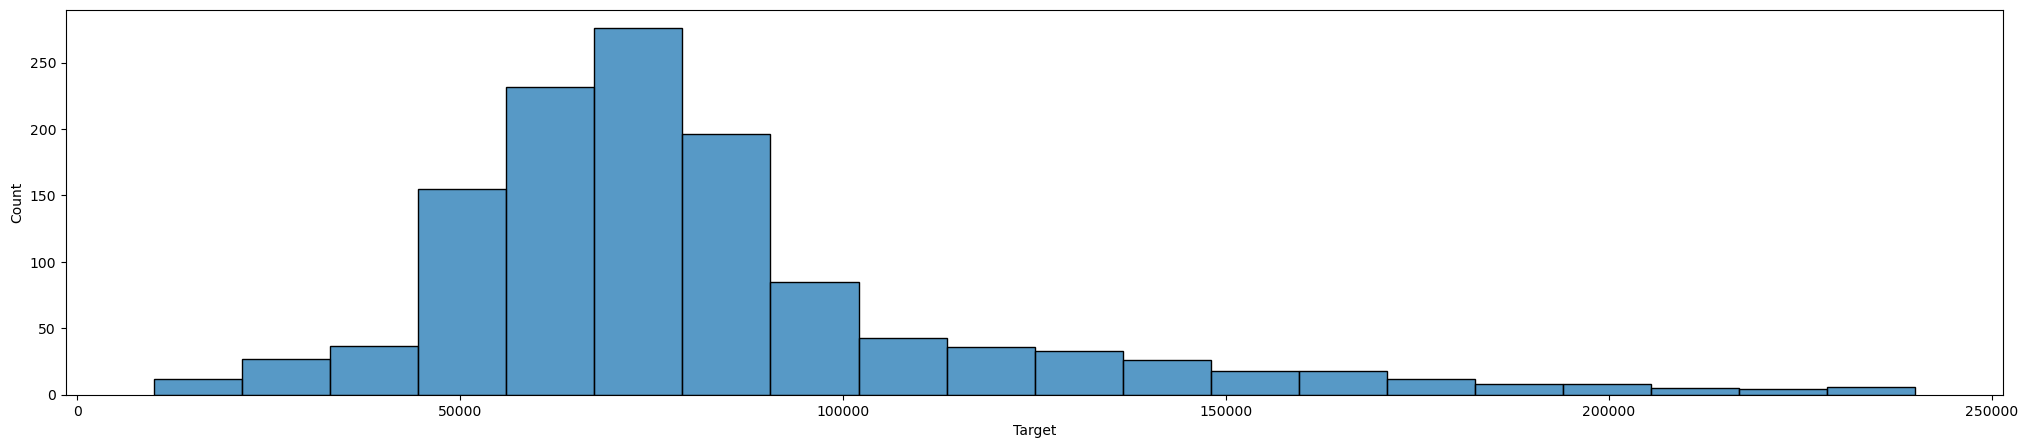

In [865]:
sns.histplot(df['Target'], bins=20)

In [866]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1237 entries, 0 to 1236
Data columns (total 20 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   index                                                   1237 non-null   int64  
 1   Timestamp                                               1237 non-null   object 
 2   Age                                                     1212 non-null   float64
 3   Gender                                                  1228 non-null   object 
 4   City                                                    1237 non-null   object 
 5   Position                                                1232 non-null   object 
 6   Total years of experience                               1222 non-null   object 
 7   Years of experience in Germany                          1207 non-null   object 
 8   Seniority level                       

### Explore the Features ###

In [867]:
def replace_low_freq(d, col, threshold=10, replacement='other'):
    value_counts = d[col].value_counts() 
    to_remove = value_counts[value_counts <= threshold].index
    tmp = d[col].replace(to_replace=to_remove, value=replacement)
    return tmp

#### Timestamp ####

In [868]:
df['Timestamp']

0       24/11/2020 11:14:15
1       24/11/2020 11:14:16
2       24/11/2020 11:14:21
3       24/11/2020 11:15:24
4       24/11/2020 11:15:46
               ...         
1232    18/01/2021 15:05:50
1233    18/01/2021 17:46:02
1234    18/01/2021 23:20:35
1235    19/01/2021 10:17:58
1236    19/01/2021 12:01:11
Name: Timestamp, Length: 1237, dtype: object

Timestamp doesn't look super useful. Values seem to be within a year or two. 

In [869]:
df = df.drop(columns=['Timestamp'])

#### Gender ####

In [870]:
df['Gender'] = df['Gender'].fillna('Other')
df['Gender'] = df['Gender'].replace('Diverse', 'Other')

#### City ####

In [871]:
df['City'].nunique()

118

In [872]:
df['City'].value_counts().head(15)

Berlin         671
Munich         234
Frankfurt       44
Hamburg         40
Stuttgart       26
Cologne         19
Amsterdam        9
Stuttgart        7
Prague           6
Karlsruhe        6
Moscow           6
Düsseldorf       6
Stockholm        5
Düsseldorf       4
Helsinki         4
Name: City, dtype: int64

In [873]:
df['City'] = replace_low_freq(df, 'City', 5, 'Other')

#### Position ####

In [874]:
df['Position '] = replace_low_freq(df, 'Position ', threshold=5, replacement='Other')

In [875]:
df['Position '].value_counts()

Software Engineer      383
Backend Developer      173
Other                  163
Data Scientist         109
Frontend Developer      88
QA Engineer             71
DevOps                  56
Mobile Developer        53
ML Engineer             41
Product Manager         38
Data Engineer           23
Designer (UI/UX)        16
Engineering Manager     10
Data Analyst             8
Name: Position , dtype: int64

#### Total Years of Experience ####

In [876]:
df['Total years of experience'].value_counts(ascending=True).head(20)

5.5                                                    1
383                                                    1
6 (not as a data scientist, but as a lab scientist)    1
31                                                     1
15, thereof 8 as CTO                                   1
2,5                                                    1
1 (as QA Engineer) / 11 in total                       1
24                                                     1
29                                                     1
28                                                     1
7.5                                                    1
6.5                                                    1
26                                                     1
40                                                     1
less than year                                         1
27                                                     2
1,5                                                    2
23                             

At first glance, a lot (maybe not all) of non-numeric values could be well represented by 0. Also, a lot of european countries use decimal commas. We can try to change the comma into a period.

In [877]:
def commaDecimal(value):
    text = str(value).strip()
    if ',' in text:
        text = text.replace(',', '.')
    try:
        num = float(text)
    except ValueError:
        num = 0
    return num

In [878]:
df['Total years of experience'] = df['Total years of experience'].apply(commaDecimal)

In [879]:
df['Total years of experience'].value_counts(ascending=True)

28.0       1
6.5        1
5.5        1
383.0      1
26.0       1
40.0       1
29.0       1
7.5        1
31.0       1
24.0       1
23.0       2
0.8        2
27.0       2
4.5        2
3.5        2
21.0       3
30.0       4
1.5        4
2.5        5
22.0       5
19.0       7
25.0       7
0.0       10
17.0      12
18.0      15
16.0      19
20.0      26
1.0       29
14.0      39
13.0      40
11.0      42
2.0       57
9.0       59
15.0      61
3.0       66
12.0      67
4.0       80
7.0       84
8.0       92
6.0       98
5.0      135
10.0     136
Name: Total years of experience, dtype: int64

#### Years of Experience in Germany ####

In [880]:
df['Years of experience in Germany'].value_counts(ascending=True).head(50)

less than year                                           1
0.2                                                      1
4,5                                                      1
0.9                                                      1
25                                                       1
26                                                       1
< 1                                                      1
3 months                                                 1
4.5                                                      1
4 (in Switzerland), 0 (in Germany)                       1
0.8                                                      1
0.1                                                      1
2.6                                                      1
17                                                       1
3 (in Poland)                                            1
<1                                                       1
4 month                                                 

In [881]:
df['Years of experience in Germany'] = df['Years of experience in Germany'].apply(commaDecimal)

In [882]:
df['Years of experience in Germany']

0       3.0
1       4.0
2       6.0
3       1.0
4       6.0
       ... 
1232    5.0
1233    1.5
1234    2.0
1235    7.0
1236    2.0
Name: Years of experience in Germany, Length: 1237, dtype: float64

#### Seniority Level ####

In [883]:
df['Seniority level'] = replace_low_freq(df, 'Seniority level', 5, 'Other')

#### Programming Languages ####

In [884]:
df[['Your main technology / programming language', 'Other technologies/programming languages you use often']] = df[['Your main technology / programming language', 'Other technologies/programming languages you use often']].fillna('')

In [885]:
df['ProgrammingLanguages'] = df['Your main technology / programming language'] + ' ' + df['Other technologies/programming languages you use often']

In [886]:
df['ProgrammingLanguages'].sort_values(ascending=False)

43      С# Python, C/C++, Javascript / Typescript, .NE...
761                                                 Офмф 
162     yaml Python, PHP, Javascript / Typescript, SQL...
1236    yaml Python, AWS, Kubernetes, Docker, terrafor...
534       typescript Javascript / Typescript, .NET, Azure
                              ...                        
734                                                      
563                                                      
757                                                      
411                                                      
425                                                      
Name: ProgrammingLanguages, Length: 1237, dtype: object

In [887]:
df

,index,Age,Gender,City,Position,Total years of experience,Years of experience in Germany,Seniority level,Your main technology / programming language,Other technologies/programming languages you use often,Salary,Bonus,Number of vacation days,Employment status,Сontract duration,Main language at work,Company size,Company type,Target,ProgrammingLanguages
0,0,26.0,Male,Munich,Software Engineer,5.0,3.0,Senior,TypeScript,"Kotlin, Javascript / Typescript",80000.0,5000.0,30,Full-time employee,Unlimited contract,English,51-100,Product,85000.0,"TypeScript Kotlin, Javascript / Typescript"
1,1,26.0,Male,Berlin,Backend Developer,7.0,4.0,Senior,Ruby,,80000.0,0.0,28,Full-time employee,Unlimited contract,English,101-1000,Product,80000.0,Ruby
2,2,29.0,Male,Berlin,Software Engineer,12.0,6.0,Lead,Javascript / Typescript,"Javascript / Typescript, Docker",120000.0,120000.0,30,Self-employed (freelancer),Temporary contract,English,101-1000,Product,240000.0,Javascript / Typescript Javascript / Typescrip...
3,3,28.0,Male,Berlin,Frontend Developer,4.0,1.0,Junior,Javascript,,54000.0,0.0,24,Full-time employee,Unlimited contract,English,51-100,Startup,54000.0,Javascript
4,4,37.0,Male,Berlin,Backend Developer,17.0,6.0,Senior,C# .NET,".NET, SQL, AWS, Docker",62000.0,0.0,29,Full-time employee,Unlimited contract,English,101-1000,Product,62000.0,"C# .NET .NET, SQL, AWS, Docker"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1232,1248,31.0,Male,Berlin,Backend Developer,9.0,5.0,Senior,Java,"Python, Javascript / Typescript, Java / Scala,...",70000.0,72000.0,26,Full-time employee,Unlimited contract,English,51-100,Product,142000.0,"Java Python, Javascript / Typescript, Java / S..."
1233,1249,33.0,Male,Berlin,Other,10.0,1.5,Senior,consumer analysis,,60000.0,3000.0,unlimited,Full-time employee,Unlimited contract,English,1000+,Product,63000.0,consumer analysis
1234,1250,39.0,Male,Munich,Other,15.0,2.0,Lead,PHP,"Python, C/C++, Javascript / Typescript, Java /...",110000.0,0.0,28,Full-time employee,Unlimited contract,English,101-1000,eCommerce,110000.0,"PHP Python, C/C++, Javascript / Typescript, Ja..."
1235,1251,26.0,Male,Other,Frontend Developer,7.0,7.0,Middle,JavaScript,"Javascript / Typescript, Docker, HTML, CSS; Ad...",38350.0,40950.0,27,Full-time employee,Unlimited contract,German,101-1000,Product,79300.0,"JavaScript Javascript / Typescript, Docker, HT..."


In [888]:
df = df.drop(columns= ['Your main technology / programming language', 'Other technologies/programming languages you use often'])

#### Vacation Days ####

In [889]:
def vacayNum(value):
    text = str(value).strip().lower()
    if text == 'unlimited':
        num = 100
    else:
        num = ''
        for i in text:
            if i in '123456890':
                num+=i
    if num == '':
        return np.nan
    else:
        return int(num)

In [890]:
df['Number of vacation days'] = df['Number of vacation days'].apply(vacayNum)

In [891]:
df['Number of vacation days'].value_counts(dropna=False)

30.0     488
28.0     231
2.0      102
25.0      89
26.0      70
24.0      68
NaN       66
29.0      23
20.0      13
21.0      10
31.0       8
100.0      8
22.0       8
32.0       8
23.0       5
36.0       5
35.0       5
40.0       4
33.0       3
0.0        3
14.0       2
15.0       2
3.0        2
12.0       2
45.0       2
365.0      1
1.0        1
34.0       1
39.0       1
5.0        1
16.0       1
50.0       1
60.0       1
38.0       1
10.0       1
Name: Number of vacation days, dtype: int64

In [892]:
df['Main language at work'].value_counts()

English               1005
German                 186
Russian                 12
Italian                  3
Spanish                  3
English and German       2
Polish                   2
Русский                  2
Czech                    2
50/50                    1
Deuglisch                1
French                   1
both                     1
Russian, English         1
Name: Main language at work, dtype: int64

There are a few people that have more than one main language at work. However, trying to deal with those values individually won't add a lot of value. The other less common main languages probably aren't representative of other people who have that main language at work so let's classify main languages with less than 3 entries as 'other'.

In [893]:
df['Main language at work'] = replace_low_freq(df, 'Main language at work', threshold=5, replacement='Other')

In [894]:
df['Main language at work'].value_counts()

English    1005
German      186
Other        19
Russian      12
Name: Main language at work, dtype: int64

let's get rid of the uncommon ones since their predictions aren't that generalizeable 

#### Employment Status ####

In [895]:
df['Employment status'].value_counts(dropna=False)

Full-time employee                                                                 1177
Self-employed (freelancer)                                                           26
NaN                                                                                  16
Part-time employee                                                                    8
Founder                                                                               3
Company Director                                                                      1
working student                                                                       1
Working Student                                                                       1
Full-time position, part-time position, & self-employed (freelancing, tutoring)       1
Intern                                                                                1
full-time, but 32 hours per week (it was my request, I'm a student)                   1
Werkstudent                     

In [896]:
df['Employment status'] = replace_low_freq(df, 'Employment status', threshold=5, replacement=np.nan)

#### Contract Duration ####

In [897]:
df['Сontract duration'].value_counts()

Unlimited contract    1148
Temporary contract      63
Name: Сontract duration, dtype: int64

#### Company Type ####

In [898]:
df['Company type'].value_counts()

Product                752
Startup                248
Consulting / Agency    141
Bank                     5
Media                    3
                      ... 
Publisher                1
Energy                   1
Enterprise               1
service                  1
eCommerce                1
Name: Company type, Length: 62, dtype: int64

In [899]:
df['Company type'] = replace_low_freq(df, 'Company type', threshold=10, replacement='Other')

<AxesSubplot:xlabel='Company type', ylabel='Target'>

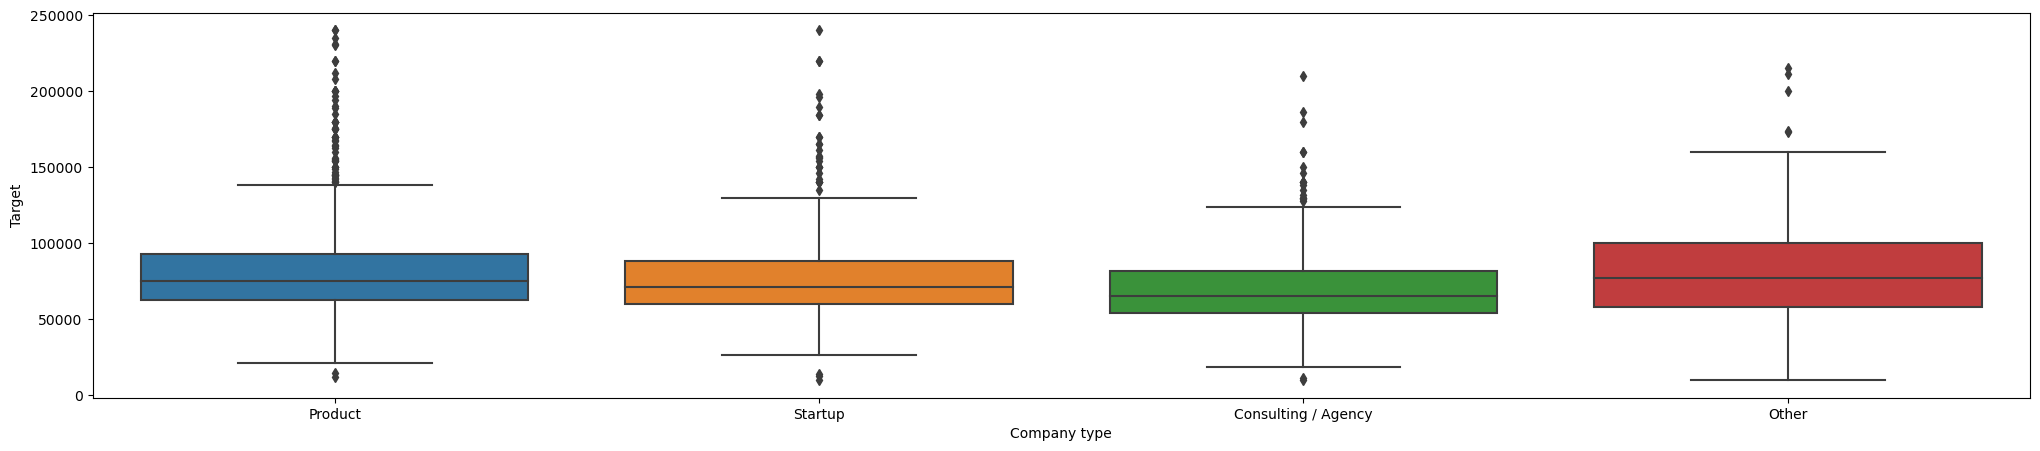

In [900]:
sns.boxplot(x=df['Company type'], y=df['Target'])

In [901]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1237 entries, 0 to 1236
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   index                           1237 non-null   int64  
 1   Age                             1212 non-null   float64
 2   Gender                          1237 non-null   object 
 3   City                            1237 non-null   object 
 4   Position                        1232 non-null   object 
 5   Total years of experience       1222 non-null   float64
 6   Years of experience in Germany  1207 non-null   float64
 7   Seniority level                 1226 non-null   object 
 8   Salary                          1237 non-null   float64
 9   Bonus                           1237 non-null   float64
 10  Number of vacation days         1171 non-null   float64
 11  Employment status               1211 non-null   object 
 12  Сontract duration               12

In [902]:
for column in df.select_dtypes(exclude=np.number).columns.to_list():
    print(df[column].value_counts().idxmax())
    df[column] = df[column].fillna(df[column].value_counts().idxmax())

Male
Berlin
Software Engineer
Senior
Full-time employee
Unlimited contract
English
1000+
Product
 


In [903]:
df.select_dtypes(exclude=np.number).columns.to_list()

['Gender',
 'City',
 'Position ',
 'Seniority level',
 'Employment status',
 'Сontract duration',
 'Main language at work',
 'Company size',
 'Company type',
 'ProgrammingLanguages']

In [904]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1237 entries, 0 to 1236
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   index                           1237 non-null   int64  
 1   Age                             1212 non-null   float64
 2   Gender                          1237 non-null   object 
 3   City                            1237 non-null   object 
 4   Position                        1237 non-null   object 
 5   Total years of experience       1222 non-null   float64
 6   Years of experience in Germany  1207 non-null   float64
 7   Seniority level                 1237 non-null   object 
 8   Salary                          1237 non-null   float64
 9   Bonus                           1237 non-null   float64
 10  Number of vacation days         1171 non-null   float64
 11  Employment status               1237 non-null   object 
 12  Сontract duration               12

In [905]:
vec_cv = CountVectorizer(max_features=100, token_pattern=r"\.?\w+[+#]*", binary=True) 
tmp = vec_cv.fit_transform(df['ProgrammingLanguages'])
tok_cols = vec_cv.get_feature_names_out()
tok_df = pd.DataFrame(tmp.toarray(), columns=tok_cols)
print("original:", df['ProgrammingLanguages'].shape)
print("vectorized:", tmp.shape)

df = pd.concat([df, tok_df], axis=1)
df = df.drop(columns=['ProgrammingLanguages','Salary','Bonus'])

original: (1237,)
vectorized: (1237, 100)


In [906]:
df

,index,Age,Gender,City,Position,Total years of experience,Years of experience in Germany,Seniority level,Number of vacation days,Employment status,...,tensorflow,terraform,ts,typescript,unix,vb,virtualisation,vms,web,yaml
0,0,26.0,Male,Munich,Software Engineer,5.0,3.0,Senior,30.0,Full-time employee,...,0,0,0,1,0,0,0,0,0,0
1,1,26.0,Male,Berlin,Backend Developer,7.0,4.0,Senior,28.0,Full-time employee,...,0,0,0,0,0,0,0,0,0,0
2,2,29.0,Male,Berlin,Software Engineer,12.0,6.0,Lead,30.0,Self-employed (freelancer),...,0,0,0,1,0,0,0,0,0,0
3,3,28.0,Male,Berlin,Frontend Developer,4.0,1.0,Junior,24.0,Full-time employee,...,0,0,0,0,0,0,0,0,0,0
4,4,37.0,Male,Berlin,Backend Developer,17.0,6.0,Senior,29.0,Full-time employee,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1232,1248,31.0,Male,Berlin,Backend Developer,9.0,5.0,Senior,26.0,Full-time employee,...,0,0,0,1,0,0,0,0,0,0
1233,1249,33.0,Male,Berlin,Other,10.0,1.5,Senior,100.0,Full-time employee,...,0,0,0,0,0,0,0,0,0,0
1234,1250,39.0,Male,Munich,Other,15.0,2.0,Lead,28.0,Full-time employee,...,0,0,0,1,0,0,0,0,0,0
1235,1251,26.0,Male,Other,Frontend Developer,7.0,7.0,Middle,2.0,Full-time employee,...,0,0,0,1,0,0,0,0,0,0


In [907]:
df.dtypes

index               int64
Age               float64
Gender             object
City               object
Position           object
                   ...   
vb                  int64
virtualisation      int64
vms                 int64
web                 int64
yaml                int64
Length: 115, dtype: object

In [908]:
df.select_dtypes(include=np.number).columns.to_list()

['index',
 'Age',
 'Total years of experience',
 'Years of experience in Germany',
 'Number of vacation days',
 'Target',
 '.js',
 '.net',
 'abap',
 'adobe',
 'android',
 'angular',
 'ansible',
 'apache',
 'automation',
 'aws',
 'azure',
 'bash',
 'bi',
 'c',
 'c#',
 'c++',
 'clojure',
 'cloud',
 'core',
 'dart',
 'data',
 'devops',
 'django',
 'docker',
 'dwh',
 'elixir',
 'embedded',
 'erlang',
 'figma',
 'flutter',
 'frontend',
 'gcp',
 'go',
 'golang',
 'google',
 'groovy',
 'hadoop',
 'helm',
 'hive',
 'ios',
 'java',
 'javascript',
 'jira',
 'js',
 'k8s',
 'kernel',
 'kotlin',
 'kubernetes',
 'linux',
 'management',
 'matlab',
 'ml',
 'network',
 'networking',
 'nlp',
 'node',
 'nodejs',
 'objective',
 'on',
 'oracle',
 'perl',
 'php',
 'pl',
 'platform',
 'platforms',
 'plotly',
 'postgre',
 'postgres',
 'power',
 'powercenter',
 'pythin',
 'python',
 'pytorch',
 'qa',
 'qlik',
 'r',
 'rails',
 'react',
 'ruby',
 'rust',
 'sap',
 'sas',
 'scala',
 'scripts',
 'shell',
 'sketch',

In [909]:
numeric_features_ = df.select_dtypes(include=np.number).columns.to_list()
numeric_features_.remove('Target')
numeric_transformer_ = Pipeline( steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", MinMaxScaler())
    ])

categorical_features_ = df.select_dtypes(exclude=np.number).columns.to_list()
categorical_transformer_ = OneHotEncoder()

preprocessor_ = ColumnTransformer( transformers=[
        ("num", numeric_transformer_, numeric_features_),
        ("cat", categorical_transformer_, categorical_features_)
    ])

In [911]:
y = df["Target"]
x = df.drop(columns={"Target"})
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

estimator = RandomForestRegressor(n_jobs=-1)
pipe = Pipeline( steps = [
        ("pre", preprocessor_),
        ("forest", estimator)]
        )
# params_ = {'forest__max_depth':[5,6,7,8,9], 
#             "forest__n_estimators":[75,100,125],
#         #     "forest__max_features":[7,8,9,10,11,12,13,14]
#         }
 
# clf_ = GridSearchCV(pipe, param_grid=params_, cv=5, n_jobs=-1) 
clf_ = pipe
clf_.fit(x_train, y_train)
# best_ = clf_.best_estimator_
print(clf_.score(x_train, y_train))
print(clf_.score(x_test, y_test))

0.8926085724283596
0.18176336051406816


# Answers and Explainations
(Expand/modify as needed)

### Results

### Feature Selection Activities

### Hyperparameter Changes